In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
import math

In [61]:
def read_complete_dataset(dataset,
                          device,
                          sensor_streams,
                          activities,
                          anomaly_percentile=100):

    dataset_folder = '../datasets/'

    dataset_path = dataset_folder + dataset + '-complete/'
    df = pd.read_pickle(dataset_path + device + '.p')
    df = df.filter(regex=sensor_streams + '|label')

    value_columns = df.filter(regex=sensor_streams).columns

    null_df = df.loc[df.label == configuration['activities'].index('Null')]

    activities_i = [configuration['activities'].index(a) for a in activities]
    df = df.loc[df.label.isin(activities_i)]

    null_mean = null_df[value_columns].mean()
    null_std = null_df[value_columns].std()

    if anomaly_percentile < 100:
        anomalies = (((df[value_columns] - null_mean) / null_std) ** 2).sum(axis=1).apply(np.sqrt)
        df['anomalies'] = anomalies

    df[value_columns] = (df[value_columns] - null_mean) / null_std

    if anomaly_percentile < 100:
        anomaly_threshold = np.percentile(df.anomalies.values, 100 - anomaly_percentile)
        print(anomaly_threshold)
        df = df.loc[df.anomalies > anomaly_threshold]

    return df[value_columns].values, df.label.values


In [77]:
sensor_streams = 'MICROPHONE_fft'
activities = [
    "Dishes",
    "Microwave",
    "Coffee",
#     "Null",
#         "Faucet",
    "Kettle",
#         "Phone ringing",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
#         "Microwave door opened",
#         "Microwave door closed",
#         "Cupboard door opened",
#         "Cupboard door closed",
#         "Microwave button press",
#     "Taking ice",
#         "Making popcorn in microwave",
#         "Room lights off",
    "Knocking",
#         "Frequency sweep",
    "Phone vibrating"
]


anomaly_percentile = 50

x_train, y_train = read_complete_dataset(device='128.237.247.134',
                                                    dataset='scott-final-iter1',
                                                    activities=activities,
                                                    sensor_streams=sensor_streams,
                                                    anomaly_percentile=anomaly_percentile)
x_test, y_test = read_complete_dataset(device='128.237.248.186',
                                                  dataset='scott-final-iter1',
                                                  activities=activities,
                                                  sensor_streams=sensor_streams,
                                                  anomaly_percentile=anomaly_percentile)

# ppl = Pipeline([
#     ('impute', Imputer()),
# #     ('clf', OneVsRestClassifier(RandomForestClassifier()))
#     ('clf', svm.SVC(kernel='linear',
#                     decision_function_shape='ovr'))
# #     ('clf', LogisticRegression())
# ])

# ppl.fit(x_train, y_train)

# predicted = ppl.predict(x_test)
# accuracy_score(y_test, predicted)

12.6497800959
14.3692309469


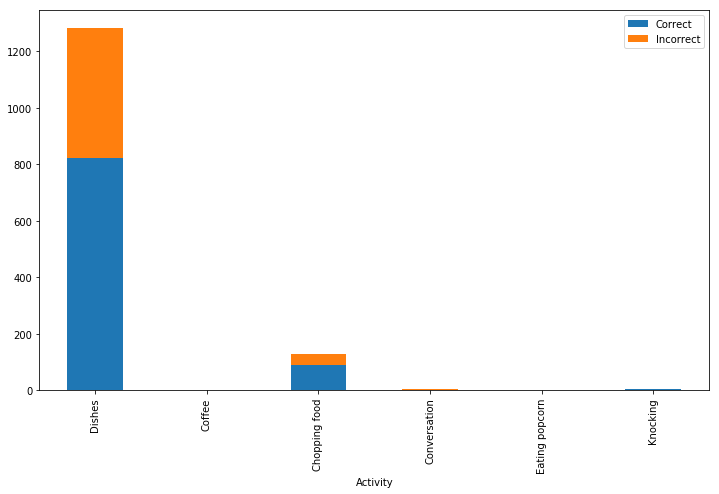

In [73]:
results = []
configuration = tflscripts.read_configuration()
for i in np.unique(y_test):
    activity = configuration['activities'][int(i)]
    correct = len([x for x in predicted[y_test == i] if x == i])
    incorrect = len([x for x in predicted[y_test == i] if x != i])
    results.append([activity, correct, incorrect])
results = pd.DataFrame(results)
results.columns = ['Activity', 'Correct', 'Incorrect']
results = results.set_index('Activity')
results.plot.bar(stacked=True)

In [93]:
sensor_streams = 'MICROPHONE_fft'
activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Kettle",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
    "Knocking",
    "Phone vibrating"
]

tests = [
    ['synergy-final-iter1', '128.237.254.195', 'synergy-final-iter2', '128.237.248.186'],
    ['scott-final-iter1', '128.237.247.134', 'synergy-final-iter2', '128.237.248.186'],
    ['scott-final-iter1', '128.237.247.134', 'scott-final-iter1', '128.237.248.186'],
    ['robotics-final', '128.237.246.127', 'scott-final-iter1', '128.237.247.134'],
    ['robotics-final', '128.237.246.127', 'robotics-final', '128.237.247.134'],
]

test_labels = [
    'Synergy, sink, replica',
    'Scott (right) to Synergy (sink)',
    'Scott (right) to Scott (left)',
    'Robotics (coffee) to Scott (right)',
    'Robotics (coffee) to Robotics (sink)',
]

percentiles = [5, 10, 30, 50, 100]

In [78]:
results = []
accuracies = []


for n, test in enumerate(tests):
    source_dataset = test[0]
    source_device = test[1]
    target_dataset = test[2]
    target_device = test[3]

    for percentile in percentiles:
        x_train, y_train = read_complete_dataset(device=source_device,
                                                 dataset=source_dataset,
                                                 activities=activities,
                                                 sensor_streams=sensor_streams,
                                                 anomaly_percentile=percentile)
        x_test, y_test = read_complete_dataset(device=target_device,
                                               dataset=target_dataset,
                                               activities=activities,
                                               sensor_streams=sensor_streams,
                                               anomaly_percentile=percentile)

        ppl = Pipeline([
            ('impute', Imputer()),
        #     ('clf', OneVsRestClassifier(RandomForestClassifier()))
            ('clf', svm.SVC(kernel='linear',
                            decision_function_shape='ovr'))
        #     ('clf', LogisticRegression())
        ])

        ppl.fit(x_train, y_train)

        predicted = ppl.predict(x_test)
        accuracy = accuracy_score(y_test, predicted)
        accuracies.append([n, percentile, accuracy])

        configuration = tflscripts.read_configuration()
        for i in np.unique(y_test):
            activity = configuration['activities'][int(i)]
            correct = len([x for x in predicted[y_test == i] if x == i])
            incorrect = len([x for x in predicted[y_test == i] if x != i])
            results.append([n, percentile, activity, correct, incorrect])

126.413420032
124.521030084
77.4839562078
89.6785812096
15.1012441837
18.0898810534
11.2701604014
12.3253400497
43.191655378
124.521030084
36.7200993425
89.6785812096
16.5866187795
18.0898810534
12.6497800959
12.3253400497
43.191655378
142.576606483
36.7200993425
121.625209175
16.5866187795
21.1716211946
12.6497800959
14.3692309469
34.3161762557
43.191655378
19.4378881934
36.7200993425
12.1912566052
16.5866187795
10.7423326542
12.6497800959
34.3161762557
51.0346478961
19.4378881934
30.2714037381
12.1912566052
15.7735843315
10.7423326542
13.5642402009


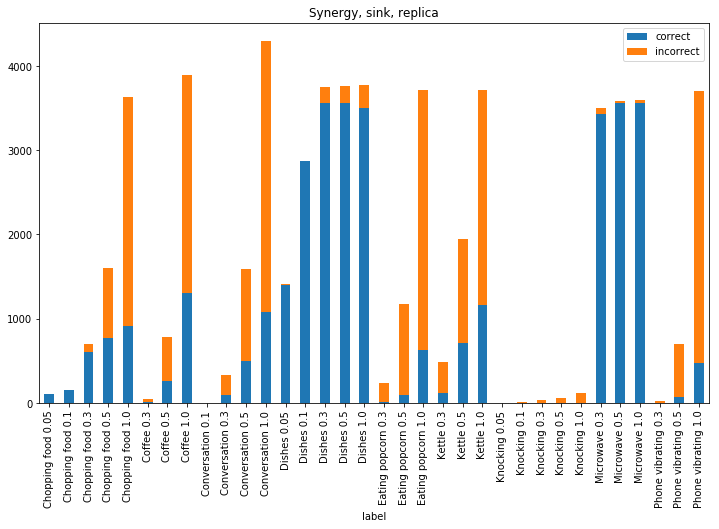

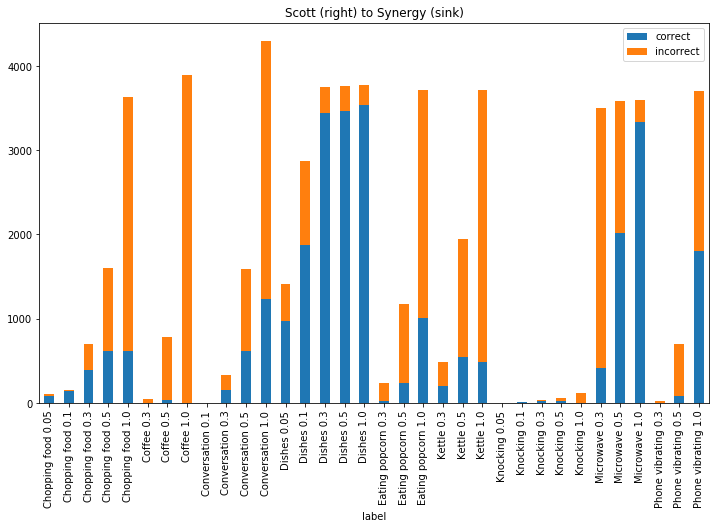

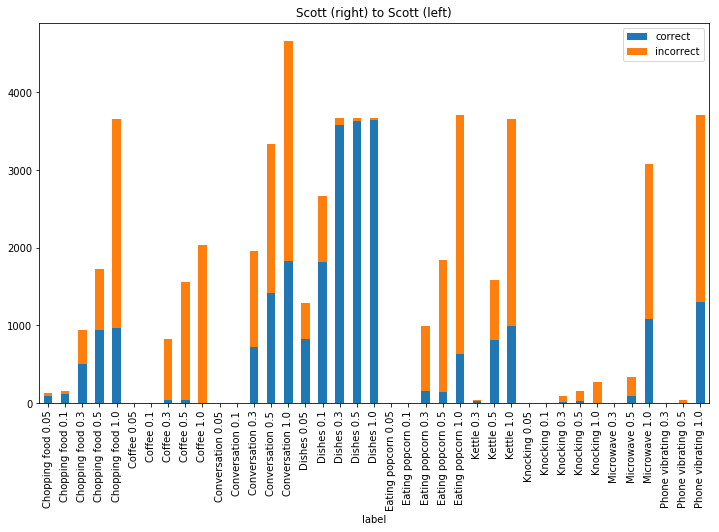

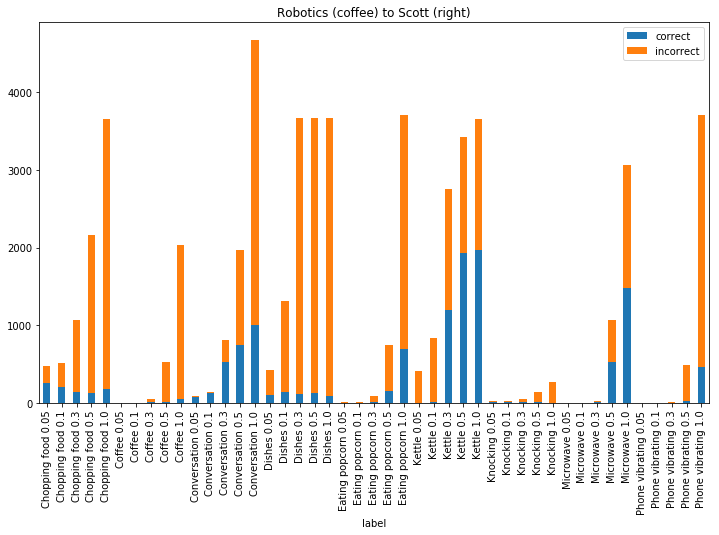

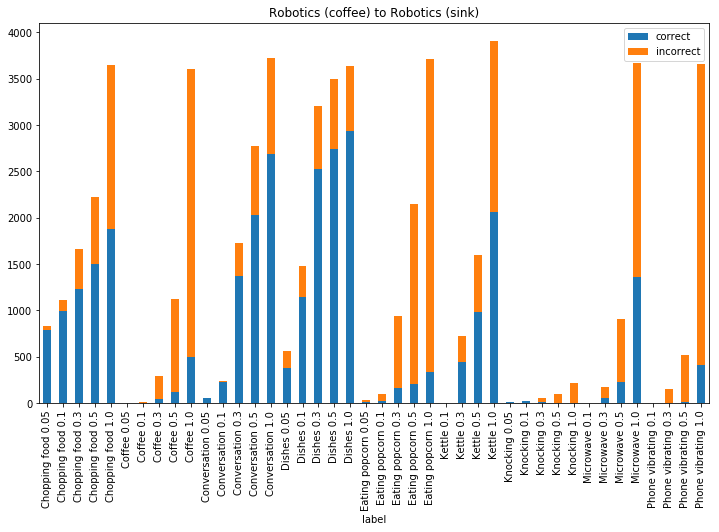

In [96]:
for i, label in enumerate(test_labels):
    subdf = results_df.loc[results_df.test == i]
    subdf = subdf[['label', 'correct', 'incorrect']]
    subdf = subdf.set_index('label')
    subdf.plot.bar(stacked=True)
    plt.title(label)

In [95]:
results_df = pd.DataFrame(results)
results_df.columns = ['test', 'anomaly_percentile', 'activity', 'correct', 'incorrect']
results_df['label'] = results_df.activity + ' ' + (results_df.anomaly_percentile / 100).astype(str)
results_df = results_df.sort_values('label')
results_df

,test,anomaly_percentile,activity,correct,incorrect,label
35,1,5,Chopping food,83,26,Chopping food 0.05
111,3,5,Chopping food,251,217,Chopping food 0.05
154,4,5,Chopping food,788,48,Chopping food 0.05
70,2,5,Chopping food,88,42,Chopping food 0.05
1,0,5,Chopping food,109,0,Chopping food 0.05
4,0,10,Chopping food,160,0,Chopping food 0.1
38,1,10,Chopping food,138,22,Chopping food 0.1
162,4,10,Chopping food,991,124,Chopping food 0.1
120,3,10,Chopping food,198,319,Chopping food 0.1
76,2,10,Chopping food,116,45,Chopping food 0.1


In [46]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test, predicted))
# cm.index = activities
# cm.columns = activities
cm

,0,1,2,3,4,5,6,7,8
0,3531,2,0,66,161,6,3,0,3
1,0,3333,0,26,24,203,2,0,9
2,1,322,0,65,298,505,1070,0,1625
3,13,158,1,486,518,216,1110,0,1212
4,34,233,0,352,621,313,898,0,1178
5,10,377,0,117,303,1240,875,0,1377
6,40,204,1,217,398,393,1009,0,1448
7,1,5,0,3,23,39,20,6,26
8,2,135,1,50,288,426,986,0,1808


In [239]:
x, y = get_dataset_and_filter_outliers('128.237.248.186', 'synergy-final-iter2', 10)

train_test_split = np.random.rand(len(x)) < 0.70
x_train = x[train_test_split]
y_train = y[train_test_split]
x_test = x[~train_test_split]
y_test = y[~train_test_split]

ppl = Pipeline([
    ('impute', Imputer()),
#     ('clf', OneVsRestClassifier(RandomForestClassifier()))
    ('clf', svm.SVC(kernel='linear', decision_function_shape='ovr'))
#     ('clf', LogisticRegression())
])

ppl.fit(x_train, y_train)

predicted = ppl.predict(x_test)
accuracy_score(y_test, predicted)

0.52209248014946286